In [115]:
from astroquery.gaia import Gaia
from astropy.coordinates import SkyCoord
import astropy.units as u
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

In [116]:
def query_stars(load=False):
    """
    Query Gaia DR3 for stars within a specified radius of given coordinates,
    filtering for stars with proper motion greater than pm_thresh.

    Parameters:

    Returns:
    - Pandas DataFrame containing the Gaia stars meeting the criteria.
    """

    # Construct query to get distance to the object by getting parralax of the closest star
    if load:
        df = pd.read_csv('d_query.csv')
    else:
        distance_query = """
        SELECT *
        FROM gaiadr3.gaia_source
        WHERE   parallax_over_error > 20
            AND (1000/parallax) < 100
        """
        print("Querying Gaia Archive for distance... This may take a few seconds.")
        # Row limit -1
        Gaia.ROW_LIMIT = -1
        dist_job = Gaia.launch_job_async(distance_query)
        dist_results = dist_job.get_results()
        df = dist_results.to_pandas()

        # Save the df
        df.to_csv('d_query.csv')

    return df

df = query_stars(load=True)

In [117]:
# Plot color-magnitude diagram
points = {
    'p0': (-1,5),
    'p1': (1,13),
    'p2': (2,17.5),
    'p3': (3,20),
    'p4': (4,22),
}

def make_line_seg(points):
    line_seg = []

    for i in range(len(points) - 1):
        x_i = ((points[f'p{i}'], points[f'p{i+1}']))
        line_seg.append(x_i) 

    return line_seg

line_seg = make_line_seg(points)


In [118]:

def count_stars_above_line(data, line_segments,mag_ug=False):
    num_outliers = 0
    outlier_indices = []

    for idx, row in data.iterrows():
        if mag_ug:
            x_star, y_star = row['u-g'], row['u']

        else:
            x_star,y_star = row['bp_rp'], row['phot_g_mean_mag']

        # Find the corresponding line segment
        for (x1, y1), (x2, y2) in line_segments:
            if x1 <= x_star <= x2:  # Check if star is within segment range
                # Linear interpolation of y on the line segment
                y_line = y1 + (y2 - y1) * (x_star - x1) / (x2 - x1)

                # Check if star is below the line (fainter magnitude)
                if y_star > y_line:
                    num_outliers += 1
                    outlier_indices.append(idx)
                break  # Each star can be checked in one segment at most

    result_dict = {
        'num_outliers': num_outliers,
        'outlier_indices': outlier_indices,
    }

    return result_dict

In [119]:
def process_ug_df(df):
    df_new = df.copy()
    df_new.loc[:,'u-g'] = df_new['u'] - df_new['g'] 
    df_new.loc[:,'bp_rp'] = df_new['phot_bp_mean_mag'] - df_new['phot_rp_mean_mag'] 

    return df_new


In [120]:
# Make a color magnitude diagram
def plot_color_magnitude_diagram(r, 
                                 line_segments=None, 
                                 ssize=5,
                                 boring_plot=False,
                                 ot_line_color='cyan',
                                    mag_ug=False,
                                    save_file=None
                                 ):
    
    wd_sample = None

    if mag_ug:
        # Extract necessary columns (g band magnitude and u-g color)
        abs_mag_col = 'u'
        color_col = 'u-g'
        xlbl = 'u - g [mag]'
        ylbl = 'Absolute Magnitude U band [mag]'
    else:
        # Extract necessary columns (g band magnitude and bp-rp color)
        abs_mag_col = 'phot_g_mean_mag'
        color_col = 'bp_rp'
        xlbl = 'BP - RP [mag]'
        ylbl = 'Absolute Magnitude G band [mag]'

    # Create the plot
    fig, ax = plt.subplots(figsize=(16/2., 9/2.))

    if line_segments:
        hw_part = 'c'
        result_dict = count_stars_above_line(r, line_segments,mag_ug=mag_ug)

    
        # Plot the outliers
        ot_indices = result_dict['outlier_indices']
        mask = r.index.isin(ot_indices)
        ax.scatter(
            r[color_col][mask],
            r[abs_mag_col][mask],
            s=ssize,
            c=ot_line_color,
            alpha=0.4,
            edgecolor='k',
            label='White Dwarfs'
        )

        # Plot the rest of the stars
        ax.scatter(
            r[color_col][~mask],
            r[abs_mag_col][~mask],
            s=ssize,
            c='black',
            alpha=0.4,
            edgecolor='k',
            label='Other Stars'
        )

        print(f'Number of outliers: {result_dict["num_outliers"]}')
        wd_sample = r[mask]


        for segment in line_segments:
            (x1, y1), (x2, y2) = segment
            ax.plot([x1, x2], [y1, y2],c=ot_line_color, linestyle='--', linewidth=1,
                    )
            
    # Add annotation for the number of outliers line

        chose_pnt = line_segments[len(line_segments)//2][0]
        num_outliers = result_dict['num_outliers']
        ot_text = f'White Dwarfs: {num_outliers} stars'
        
        ax.annotate(ot_text,
             c=ot_line_color,
             xy=(chose_pnt[0], chose_pnt[1]),
             xytext=(chose_pnt[0] + 0.5, chose_pnt[1] - 1),
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.3', color=ot_line_color),
             fontsize=12,
             bbox=dict(boxstyle='round', facecolor='grey', edgecolor=ot_line_color, alpha=0.5)
             )
        
        
    if boring_plot:
        # Create a color map based on the BP-RP color index
        colors = r['parallax_error']
        hw_part = 'b'
        scatter = ax.scatter(
        r[color_col],
        r[abs_mag_col], 
        s=ssize, 
        c=colors, 
        alpha=0.4,  # Increase transparency
        edgecolor='k',  # Optional for clarity
        label='Cluster Stars',
        cmap='plasma',
        norm=LogNorm()  # Apply logarithmic normalization
         )
        # Add a color bar to show the colormap scale
        cbar = plt.colorbar(scatter, ax=ax)
        cbar.set_label(r'Parallax Error', fontsize=12)
        
    ax.set_xlabel(xlbl, fontsize=12)
    ax.set_ylabel(ylbl, fontsize=12)
    ax.set_title('Color-Magnitude Diagram', fontsize=14)
    ax.invert_yaxis()
    ax.grid(True, linestyle='--', alpha=0.6)


    ax.legend()

    if save_file:
        plt.savefig(save_file, dpi=400, bbox_inches='tight')

    else:
        plt.savefig(f'cmd_part_{hw_part}.png', dpi=400, bbox_inches='tight')

    plt.show()


    return wd_sample




Number of outliers: 19429


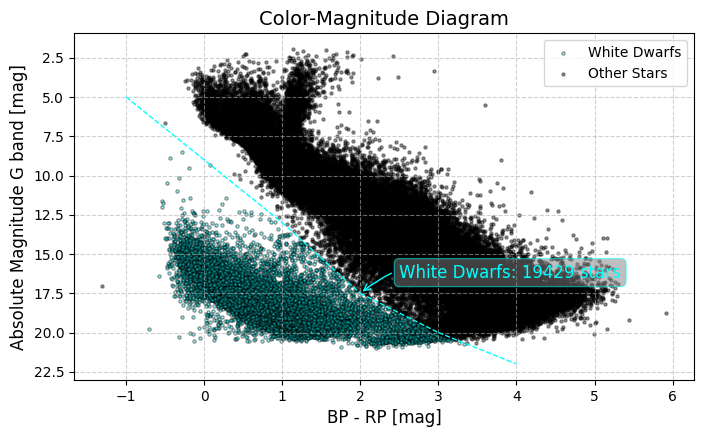

,Unnamed: 0,solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,...,azero_gspphot,azero_gspphot_lower,azero_gspphot_upper,ag_gspphot,ag_gspphot_lower,ag_gspphot_upper,ebpminrp_gspphot,ebpminrp_gspphot_lower,ebpminrp_gspphot_upper,libname_gspphot
0,0,1636148068921376768,Gaia DR3 1451503404777191936,1451503404777191936,415220063,2016.0,207.153819,0.360702,27.196561,0.279023,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,1636148068921376768,Gaia DR3 4050943987628929792,4050943987628929792,479317220,2016.0,272.469069,0.811179,-27.922945,0.534769,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,1636148068921376768,Gaia DR3 4123603568470516352,4123603568470516352,50208071,2016.0,264.458296,1.251677,-17.089808,1.063817,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,5,1636148068921376768,Gaia DR3 3098800766422701312,3098800766422701312,1563170227,2016.0,100.943159,1.216359,-8.445374,1.530319,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,6,1636148068921376768,Gaia DR3 1571907865120140544,1571907865120140544,356727513,2016.0,186.949929,0.407876,52.375869,0.426846,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297400,297400,1636148068921376768,Gaia DR3 4698424845771339520,4698424845771339520,1087897205,2016.0,25.750304,0.010807,-67.312958,0.009853,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
297410,297410,1636148068921376768,Gaia DR3 5273943488410008832,5273943488410008832,821697039,2016.0,118.301184,0.011445,-67.798672,0.011561,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
297411,297411,1636148068921376768,Gaia DR3 5332606522595645952,5332606522595645952,778663322,2016.0,176.456647,0.013777,-64.843053,0.015098,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
297413,297413,1636148068921376768,Gaia DR3 2552928187080872832,2552928187080872832,1160313233,2016.0,12.296740,0.016581,5.376557,0.008281,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [121]:
plot_color_magnitude_diagram(df, line_segments=line_seg, boring_plot=False,mag_ug=False)

In [123]:
def query_sdss_xmatch(load=False):
    """
    Query Gaia DR3 for stars within a specified radius of given coordinates,
    filtering for stars with proper motion greater than pm_thresh.

    Parameters:

    Returns:
    - Pandas DataFrame containing the Gaia stars meeting the criteria.
    """
    if load:
        df = pd.read_csv('sdss_df.csv')
    else:
        distance_query = """
        SELECT g.phot_g_mean_mag, g.phot_bp_mean_mag, g.phot_rp_mean_mag,
                g.parallax,g.parallax_error, q_sdss.objid, q_sdss.u, q_sdss.g, q_sdss.r, q_sdss.i, q_sdss.z


        FROM gaiadr3.sdssdr13_best_neighbour as best_neighbour

        INNER JOIN gaiadr3.gaia_source as g ON g.source_id = best_neighbour.source_id

        INNER JOIN external.sdssdr13_photoprimary as q_sdss ON q_sdss.objid = best_neighbour.original_ext_source_id

        WHERE (g.parallax > 10) 
        AND (g.phot_bp_mean_flux_over_error > 5) 
        AND (g.phot_rp_mean_flux_over_error > 5) 
        AND (g.parallax_over_error > 20)
        """
        print("Querying Gaia Archive for distance... This may take a few seconds.")
        # Row limit -1
        Gaia.ROW_LIMIT = -1
        dist_job = Gaia.launch_job_async(distance_query)
        dist_results = dist_job.get_results()
        df = dist_results.to_pandas()

        # Save the df
        df.to_csv('sdss_df.csv', index=False)

    return df

sdss_df = query_sdss_xmatch(load=True)

In [124]:
df_temp = sdss_df.copy()
df_temp = process_ug_df(df_temp)

final_df = df_temp[(df_temp['u'] >-50) & (df_temp['u-g'] <100)]


In [125]:
final_df.min()

phot_g_mean_mag     2.324510e+00
phot_bp_mean_mag    3.367760e+00
phot_rp_mean_mag    2.016453e+00
parallax            1.000001e+01
parallax_error      8.349143e-03
objid               1.237646e+18
u                   5.543479e+00
g                   6.067814e+00
r                  -9.999000e+03
i                  -9.999000e+03
z                  -9.999000e+03
u-g                -2.856124e+01
bp_rp              -5.143790e-01
dtype: float64

In [126]:
final_df

,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,parallax,parallax_error,objid,u,g,r,i,z,u-g,bp_rp
0,9.981492,10.466039,9.336716,10.967355,0.036335,1237662981572330020,15.37119,14.05626,13.14883,12.19866,12.72760,1.31493,1.129323
1,17.469687,19.426530,16.167704,10.019123,0.091845,1237668573626108662,23.37180,20.11458,18.47906,16.74483,15.82025,3.25722,3.258826
2,13.719134,15.162105,12.543299,19.049086,0.016128,1237668573625975613,18.24972,15.73283,14.32499,13.00813,12.32557,2.51689,2.618806
3,14.666202,16.198835,13.455311,11.034884,0.036990,1237668573626042712,19.27417,16.82238,15.36163,13.95735,13.21826,2.45179,2.743524
4,13.490684,14.752601,12.297461,14.881135,0.075285,1237668573626041200,17.50990,15.50928,12.94487,13.86971,12.81478,2.00062,2.455140
...,...,...,...,...,...,...,...,...,...,...,...,...,...
94257,17.759884,20.160360,16.354782,16.058079,0.124501,1237680327331545300,24.17539,21.08147,19.20148,17.01460,15.89221,3.09392,3.805578
94258,15.466990,16.922277,14.284175,10.143307,0.031856,1237680327331742580,20.34365,17.54603,16.11519,14.78190,14.06973,2.79762,2.638102
94259,19.295792,19.848440,18.618958,13.815151,0.295091,1237680473360958461,21.93451,20.07945,19.26647,18.96334,18.85142,1.85506,1.229482
94260,12.013978,12.686489,11.223702,10.589558,0.020847,1237680327332003918,15.61437,14.52515,12.17546,11.77407,12.36099,1.08922,1.462787


In [153]:
y_offset = 2.5

# Plot color-magnitude diagram
points = {
    'p0': (-1,5+y_offset),
    'p1': (1,13+y_offset),
    'p2': (2,17.5+y_offset),
    'p3': (3,20+y_offset),
    'p4': (4,22+y_offset),
}

line_seg= make_line_seg(points=points)

Number of outliers: 5361


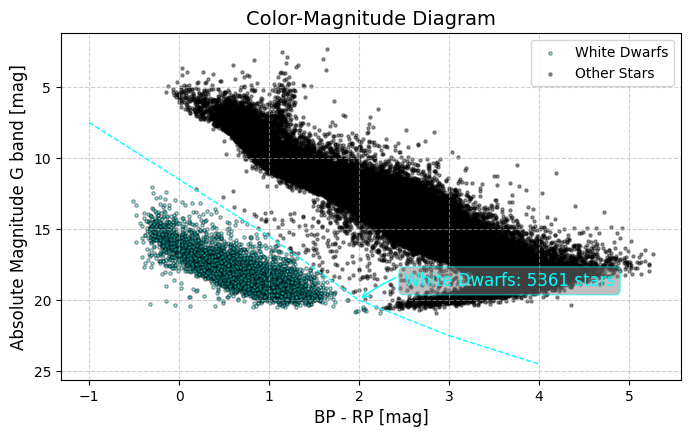

In [154]:
# G vs bp-rp
wd_sample = plot_color_magnitude_diagram(final_df, line_segments=line_seg, boring_plot=False,mag_ug=False)

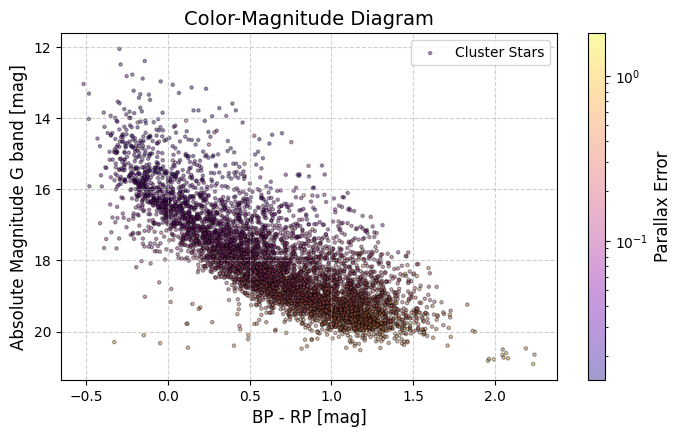

In [155]:
plot_color_magnitude_diagram(wd_sample, line_segments=None, boring_plot=True,mag_ug=False,save_file='wd_sample_gbprp_CMD.png')

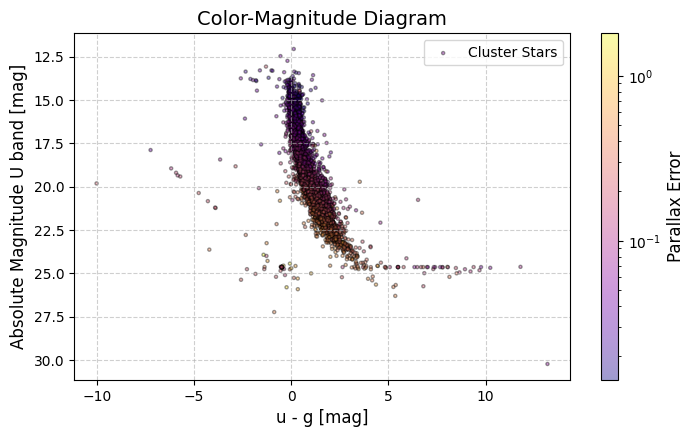

In [156]:
# U vs u-g
plot_color_magnitude_diagram(wd_sample, line_segments=None, boring_plot=True,mag_ug=True,save_file='wd_sample_ug_CMD.png')

In [157]:
spectra_wd_df = pd.read_csv('SDSS_WDs.csv')

In [158]:
spectra_wd_df.columns

Index(['WDID', 'NAME', 'ICRSRA', 'ICRSDEC', 'SPECTYPE', 'TEFF', 'LOGG', 'DPC',
       'V', 'SU', 'OBJID', 'RUN', 'RERUN', 'CAMCOL', 'FIELD', 'TYPE', 'MAG_U',
       'MAG_G', 'MAG_R', 'MAG_I', 'MAG_Z'],
      dtype='object')

In [159]:
wd_sample.head()

,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,parallax,parallax_error,objid,u,g,r,i,z,u-g,bp_rp
44,16.716326,16.706924,16.711035,10.224600,0.059361,1237662979961521284,16.63687,16.63070,16.84549,17.03000,17.29035,0.00617,-0.004111
49,14.601588,14.649755,14.523473,33.140241,0.022917,1237668689580263743,15.36962,14.97778,16.28928,15.17993,15.29479,0.39184,0.126282
67,17.579939,17.725334,17.343970,12.638934,0.085002,1237671970400108668,18.20058,17.72147,17.62349,17.63943,17.75623,0.47911,0.381364
75,17.518778,17.478075,17.585090,11.596022,0.064303,1237671941419696288,17.42231,17.41217,17.66498,17.85664,18.12498,0.01014,-0.107015
150,17.635767,17.874210,17.156927,16.755668,0.080065,1237663232827981861,18.63056,17.92389,17.59955,17.28823,17.38114,0.70667,0.717283


In [160]:
working_df = pd.merge(wd_sample, spectra_wd_df, left_on='objid', right_on='OBJID', how='inner')

In [161]:
wd_DA = working_df[working_df['SPECTYPE'] == 'DA']
wd_DB = working_df[working_df['SPECTYPE'] == 'DB']
wd_DQ = working_df[working_df['SPECTYPE'] == 'DQ']

In [162]:
print(f'Number of DA white dwarfs: {len(wd_DA)}')

print(f'Number of DB white dwarfs: {len(wd_DB)}')

print(f'Number of DQ white dwarfs: {len(wd_DQ)}')


Number of DA white dwarfs: 442
Number of DB white dwarfs: 6
Number of DQ white dwarfs: 26


In [163]:
# Spectral type masks
mask_DA = working_df['SPECTYPE'] == 'DA'
mask_DB = working_df['SPECTYPE'] == 'DB'
mask_DQ = working_df['SPECTYPE'] == 'DQ'

mask_list = [mask_DA, mask_DB, mask_DQ]

In [164]:
def plot_wd_cmd(df_full,df,mask_list=None,clrs = ['crimson','lime','cyan'],lbls=['DA','DB','DQ'],ssize=5,marker='.',save_file=None):
    fig, ax = plt.subplots(figsize=(16/2., 9/2.))

    # Plot the white dwarfs
    ax.scatter(df_full['bp_rp'],df_full['phot_g_mean_mag'],s=ssize,label='White Dwarfs',c='black',alpha=0.3,edgecolor=None,marker=marker)

    if mask_list:
        for mask,clr,lbl in zip(mask_list,clrs,lbls):
            ax.scatter(df[mask]['bp_rp'],df[mask]['phot_g_mean_mag'],s=ssize,label=lbl,c=clr,alpha=0.9,edgecolor=None,marker=marker)

    ax.set_xlabel('BP - RP [mag]',fontsize=12)
    ax.set_ylabel('Absolute Magnitude G band [mag]',fontsize=12)
    ax.set_title('White Dwarf Color Magnitude Diagram',fontsize=14)
    ax.invert_yaxis()
    ax.grid(True,linestyle='--',alpha=0.6)
    ax.legend()

    if save_file:
        plt.savefig(save_file,dpi=800,bbox_inches='tight')

    else:
        plt.savefig('wd_cmd_masks.png',dpi=800,bbox_inches='tight')

    plt.show()

Number of pixels: 1.8


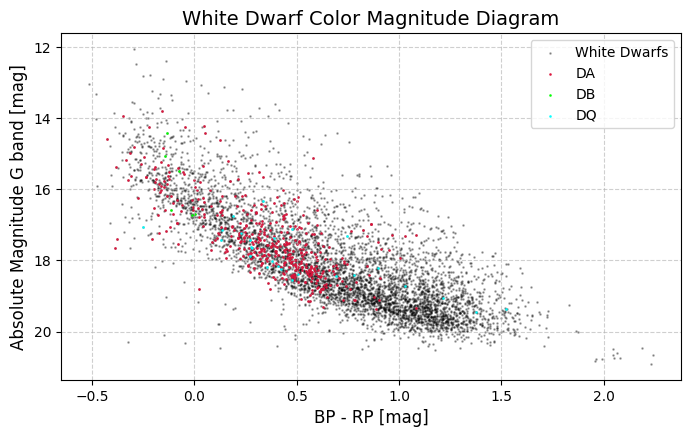

In [166]:
# Make it so one scatter point is 1 pixel
dpi = 800
num_pixels = 20
point_size = num_pixels * 72 / dpi

print(f'Number of pixels: {point_size}')

plot_wd_cmd(wd_sample,working_df,mask_list=mask_list,save_file='wd_cmd_masks.png',ssize=(point_size**2),marker='.')

In [209]:
# Define the file path
file_path = "/home/lordrick/Documents/Class_Repos/stars_and_planetsI_ucsc/homeworks/hw6/WD_CMD/Table_Mass_0.2"

# Read file content
with open(file_path, "r") as f:
    lines = f.readlines()

# Identify where tables start
table_starts = [i for i, line in enumerate(lines) if line.strip().startswith("Teff")]  # Detect column headers

# Ensure there are two tables detected
if len(table_starts) < 2:
    raise ValueError("Could not detect two tables in the file.")

print(table_starts)

# Read first table
skiprows = 1
table_end = table_starts[1] - 2
df1 = pd.read_csv(file_path, delim_whitespace=True, skiprows=skiprows, nrows=table_end - skiprows)

# Read second table
skiprows = table_starts[1] 
df2 = pd.read_csv(file_path, delim_whitespace=True, skiprows=skiprows)



[1, 45]


/tmp/ipykernel_88888/4198295511.py:20: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df1 = pd.read_csv(file_path, delim_whitespace=True, skiprows=skiprows, nrows=table_end - skiprows)
/tmp/ipykernel_88888/4198295511.py:24: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df2 = pd.read_csv(file_path, delim_whitespace=True, skiprows=skiprows)


In [210]:
df2

,Teff,log_g,Mbol,BC,U,B,V,R,I,J,...,y,G2,G2_BP,G2_RP,G3,G3_BP,G3_RP,FUV,NUV,Age
0,3250.0,7.163,15.804,-0.889,18.751,18.113,16.693,15.792,14.927,13.996,...,15.056,16.010,16.892,15.113,16.035,16.900,15.121,34.079,24.566,3.882000e+09
1,3500.0,7.162,15.479,-0.701,17.964,17.468,16.180,15.367,14.580,13.760,...,14.760,15.596,16.379,14.751,15.619,16.389,14.760,32.292,23.429,3.397000e+09
2,3750.0,7.161,15.176,-0.588,17.351,16.959,15.763,15.009,14.274,13.532,...,14.491,15.242,15.959,14.436,15.264,15.970,14.446,30.854,22.539,2.992000e+09
3,4000.0,7.159,14.891,-0.434,16.652,16.395,15.325,14.653,13.994,13.354,...,14.260,14.888,15.513,14.140,14.909,15.527,14.152,29.304,21.521,2.640000e+09
4,4250.0,7.156,14.622,-0.334,16.081,15.930,14.956,14.346,13.744,13.180,...,14.047,14.578,15.135,13.878,14.598,15.150,13.890,27.999,20.684,2.334000e+09
5,4500.0,7.154,14.367,-0.258,15.567,15.512,14.625,14.069,13.519,13.020,...,13.854,14.295,14.793,13.641,14.315,14.810,13.654,26.789,19.921,2.063000e+09
6,4750.0,7.150,14.123,-0.201,15.106,15.135,14.323,13.815,13.310,12.868,...,13.674,14.034,14.480,13.421,14.053,14.499,13.436,25.708,19.236,1.810000e+09
7,5000.0,7.145,13.888,-0.157,14.684,14.789,14.045,13.579,13.115,12.724,...,13.505,13.789,14.190,13.216,13.808,14.211,13.231,24.714,18.610,1.571000e+09
8,5250.0,7.140,13.662,-0.126,14.292,14.468,13.788,13.359,12.932,12.586,...,13.345,13.559,13.919,13.025,13.578,13.941,13.041,23.773,18.020,1.350000e+09
9,5500.0,7.132,13.442,-0.102,13.927,14.167,13.544,13.150,12.758,12.455,...,13.193,13.340,13.662,12.842,13.359,13.687,12.858,22.890,17.473,1.149000e+09


In [212]:
df1

,Teff,log_g,Mbol,BC,U,B,V,R,I,J,...,y,G2,G2_BP,G2_RP,G3,G3_BP,G3_RP,FUV,NUV,Age
0,1500.0,7.158,19.149,1.009,23.068,20.660,18.139,17.863,19.870,20.125,...,19.607,18.524,18.506,18.681,18.561,18.510,18.744,58.769,34.052,1.418000e+10
1,1750.0,7.157,18.478,0.790,22.301,20.108,17.687,17.235,18.501,18.897,...,18.569,17.881,17.986,17.718,17.911,17.990,17.768,56.737,32.976,1.166000e+10
2,2000.0,7.157,17.896,0.561,21.672,19.646,17.335,16.741,17.408,17.859,...,17.703,17.342,17.597,16.943,17.366,17.601,16.980,54.881,31.946,9.847000e+09
3,2250.0,7.156,17.383,0.332,21.133,19.249,17.051,16.345,16.553,16.964,...,16.985,16.884,17.295,16.317,16.903,17.299,16.345,53.188,31.066,8.347000e+09
4,2500.0,7.155,16.923,0.134,20.614,18.872,16.790,16.000,15.849,16.277,...,16.368,16.470,17.028,15.782,16.485,17.032,15.802,51.696,30.252,6.953000e+09
5,2750.0,7.154,16.507,-0.057,20.147,18.537,16.564,15.719,15.291,15.619,...,15.812,16.119,16.802,15.346,16.132,16.807,15.360,50.197,29.467,5.510000e+09
6,3000.0,7.153,16.127,-0.217,19.684,18.207,16.343,15.475,14.866,15.018,...,15.325,15.816,16.584,14.991,15.831,16.589,15.002,48.642,28.665,4.616000e+09
7,3250.0,7.152,15.776,-0.345,19.208,17.869,16.121,15.260,14.558,14.465,...,14.921,15.560,16.363,14.713,15.577,16.369,14.722,46.944,27.819,4.038000e+09
8,3500.0,7.150,15.450,-0.437,18.710,17.518,15.888,15.058,14.329,13.975,...,14.615,15.334,16.130,14.490,15.354,16.137,14.500,44.958,26.922,3.553000e+09
9,3750.0,7.148,15.146,-0.498,18.201,17.153,15.644,14.859,14.138,13.583,...,14.388,15.123,15.884,14.297,15.143,15.892,14.307,42.563,25.936,3.145000e+09
